In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [173]:
#generating sinusoidal data
class SineTask():
  def __init__(self,amp,phase,min_x,max_x):
    self.phase=phase
    self.max_x=max_x
    self.min_x=min_x
    self.amp=amp
    
  def sample_data(self,size=1):
    x=np.random.uniform(self.max_x,self.min_x,size)
    y=self.true_sine(x)
    x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return x,y
  
  def true_sine(self,x):
    y=self.amp*np.sin(self.phase+x)
    return y

In [174]:
class SineDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x
    self.max_x=max_x
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return SineTask(amp, phase, self.min_x, self.max_x)

In [188]:
#defining our sine-net
class SineNet(nn.Module):
  def __init__(self):
    super(SineNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  # I implemented argforward() so that I could use a set of custom weights for evaluation. 
  # This is important for the "inner loop" in MAML where you temporarily update the weights
  # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [189]:
class SineMAML():
  def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
    self.net=net
    self.weights=list(net.parameters())
    self.alpha=alpha
    self.beta=beta
    self.tasks=tasks
    self.k=k 
    self.num_tasks_meta=num_metatasks
    self.criterion=nn.MSELoss()
    self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
    self.meta_losses=[]
    self.plot_every =100
    self.print_every = 10000
    self.num_metatasks=num_metatasks

  def inner_loop(self,task):
    temp_weights=[w.clone() for w in self.weights]  #clone returns a copy of the input
    x,y=task.sample_data(size=self.k) #sampling D
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    loss=self.criterion(output,y)/self.k
    grads=torch.autograd.grad(loss,temp_weights)
    temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
    x,y=task.sample_data(size=self.k) #sampling D'
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    metaloss=self.criterion(output,y)/self.k
    return metaloss
  
  def outer_loop(self,num_epochs):
    total_loss=0
    for epoch in range(1,num_epochs+1):
      metaloss_sum=0
      for i in range(self.num_metatasks):
        task=self.tasks.sample_task()
        metaloss=self.inner_loop(task)
        metaloss_sum+=metaloss
      metagrads=torch.autograd.grad(metaloss_sum,self.weights)
      #important step
      for w,g in zip(self.weights,metagrads):
        w.grad=g
      ###############
      self.meta_optimiser.step()
      total_loss+=metaloss_sum.item()/self.num_metatasks
      if epoch % self.print_every == 0:
        print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
      if epoch%self.plot_every==0:
        self.meta_losses.append(total_loss/self.plot_every)
        total_loss = 0

In [190]:
sine_tasks=SineDistribution(0.1, 5, 0, np.pi, -5, 5)
net=SineNet()
net=net.to(device)

In [191]:
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=5,num_metatasks=10)

In [192]:
maml.outer_loop(num_epochs=20000)

10000/20000. loss: 0.29148665428161613
20000/20000. loss: 0.1836860799789429


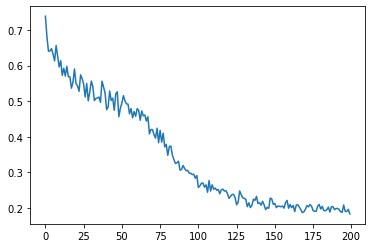

In [193]:
plt.plot(maml.meta_losses)

In [194]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.MSELoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y)
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

In [195]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='lower right')
  plt.show()

[0.9276273846626282, 0.9108113050460815, 3.396444797515869, 10.74353313446045, 12.09533977508545, 4.35939884185791, 0.9116925001144409, 0.38923364877700806, 0.3032921850681305, 0.2529469132423401]


<ipython-input-194-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


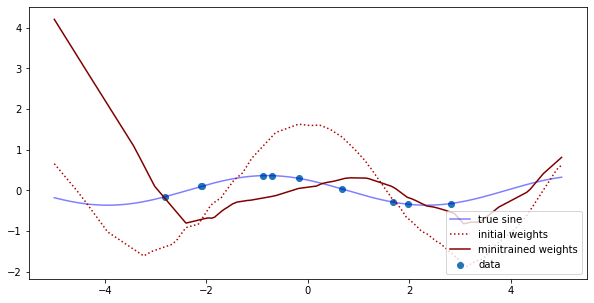

In [196]:
K=10
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

# RMSE - one sample

In [197]:
num_iterations = 400
function_tasks = SineDistribution(0.1, 5, 0, np.pi, -5, 5)

global_error = 0
count = 0

for i in range(num_iterations):
    og_net=maml.net.net
    optim=torch.optim.SGD
    lr=0.01
    
    task=function_tasks.sample_task()
    x,y=task.sample_data(K)
    x=x.to(device)
    y=y.to(device)
    outputs,axis=test(og_net,x,y,lr,optim)
    
    error = 0
    L = []
    for i in range(len(x.numpy())):
        L.append(int((5+x.numpy()[i][0])*100))
    pred = []
    for i in range(len(x.numpy())):
        pred.append(outputs['minitrained'][L[i]][0])
    y_ = []
    for i in range(len(y.numpy())):
        y_.append(y.numpy()[i][0])
        
    error = (np.linalg.norm(np.array(y_)-np.array(pred)))
    if error < 1000 and error > -1000:
        global_error += error
        count +=1
        
global_error = global_error/count

[2.080909490585327, 16.41419219970703, 13.14557933807373, 22.67278480529785, 14.756197929382324, 7.954710483551025, 1.0501196384429932, 0.551654040813446, 0.37450987100601196, 0.25418621301651]
[9.78861141204834, 47.508697509765625, 522.478271484375, 2454.81689453125, 77945.15625, 196401774460928.0, inf, nan, nan, nan]
[2.083251476287842, 20.614944458007812, 34.14555740356445, 9.014551162719727, 6.065940856933594, 0.24733571708202362, 0.17024238407611847, 0.16343356668949127, 0.15914788842201233, 0.15505485236644745]
[0.24413776397705078, 0.4023973345756531, 5.3484392166137695, 20.788715362548828, 9.533870697021484, 9.747808456420898, 12.507272720336914, 9.525623321533203, 2.191175699234009, 1.0550869703292847]


<ipython-input-194-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


[1.8844226598739624, 8.315902709960938, 18.520736694335938, 16.750974655151367, 19.12078857421875, 8.36624526977539, 7.013127326965332, 0.8079355359077454, 0.5249883532524109, 0.47057732939720154]
[9.040583610534668, 15.682785034179688, 19.43883514404297, 9.31657886505127, 1.622926115989685, 0.9891965985298157, 0.7044373154640198, 0.5974262952804565, 0.6936522126197815, 0.9580345153808594]
[4.214076042175293, 29.476428985595703, 53.63542938232422, 27.533985137939453, 12.276689529418945, 18.111167907714844, 24.391536712646484, 7.752730369567871, 5.052123546600342, 4.689813613891602]
[9.057538032531738, 72.11593627929688, 76.58491516113281, 26.17670249938965, 50.647552490234375, 135.1023712158203, 14.321101188659668, 12.543684005737305, 11.809657096862793, 11.337824821472168]
[0.0367509089410305, 0.6591104865074158, 9.697293281555176, 6.041844844818115, 0.8429262042045593, 1.4058516025543213, 3.100717306137085, 2.5873570442199707, 0.8802905082702637, 0.689312219619751]
[4.703028678894043

[0.6198634505271912, 8.962160110473633, 37.50798797607422, 31.523717880249023, 46.686058044433594, 81.17533874511719, 2.637507915496826, 1.987121820449829, 1.6275453567504883, 1.360821008682251]
[7.471550941467285, 6.061867713928223, 1.5721572637557983, 0.8598594665527344, 1.457839846611023, 1.2616231441497803, 0.3071309030056, 0.2218504399061203, 0.2800770103931427, 0.3455306887626648]
[0.26438015699386597, 1.1638277769088745, 5.116968631744385, 7.124304294586182, 3.4420275688171387, 0.35590749979019165, 0.13899151980876923, 0.1945178061723709, 0.7673341631889343, 2.3561782836914062]
[1.6170923709869385, 11.825360298156738, 5.992279052734375, 3.1411757469177246, 2.7722461223602295, 2.7223641872406006, 3.1306395530700684, 2.270047664642334, 0.8739370107650757, 0.12522125244140625]
[1.8330557346343994, 0.9772270321846008, 1.0949755907058716, 7.475212097167969, 28.372730255126953, 12.53946590423584, 5.5237836837768555, 0.8424921035766602, 0.3373504877090454, 0.27290862798690796]
[3.69582

[0.6037667393684387, 2.895942449569702, 15.012873649597168, 14.363344192504883, 2.51627516746521, 0.2922350764274597, 0.0668504536151886, 0.043522048741579056, 0.03559473529458046, 0.03080538846552372]
[1.3339991569519043, 9.046158790588379, 36.85871887207031, 7.912255764007568, 2.4073376655578613, 0.5847680568695068, 0.4723113179206848, 0.5304884314537048, 0.6178457140922546, 0.9011957049369812]
[0.22556106746196747, 2.3701367378234863, 10.939058303833008, 26.68570327758789, 76.07077026367188, 140.97434997558594, 101.38188171386719, 24.136167526245117, 185.72189331054688, 398.0458679199219]
[4.163699150085449, 7.422299385070801, 32.031944274902344, 234.5357208251953, 1896.3125, 15672.583984375, 28269066.0, 1.0507487523183608e+27, inf, nan]
[0.7043408155441284, 4.879213809967041, 29.552730560302734, 14.706939697265625, 5.155684471130371, 2.7158846855163574, 1.3838428258895874, 0.7250522375106812, 0.5150487422943115, 0.39725062251091003]
[0.866788387298584, 8.363433837890625, 22.2556571

[0.629740834236145, 1.9257314205169678, 7.374448299407959, 8.183260917663574, 1.0307155847549438, 0.5046770572662354, 0.9971688389778137, 1.1608582735061646, 1.1287363767623901, 0.28376203775405884]
[0.9456977844238281, 2.476346969604492, 0.44329848885536194, 0.9053601026535034, 1.1893243789672852, 3.3873729705810547, 2.154914140701294, 1.3182308673858643, 1.4117190837860107, 1.361151933670044]
[0.6089128255844116, 7.0301642417907715, 7.901973724365234, 4.633544445037842, 0.9592796564102173, 0.25035250186920166, 0.22458615899085999, 0.24995212256908417, 0.3144979476928711, 0.36729130148887634]
[1.1253477334976196, 0.44930610060691833, 0.45891013741493225, 1.648569107055664, 2.9801478385925293, 3.604564666748047, 0.8275678753852844, 5.1477460861206055, 6.01295804977417, 3.289607524871826]
[0.19117534160614014, 0.4648577570915222, 3.751824140548706, 46.90296173095703, 28.393096923828125, 11.620281219482422, 6.189306735992432, 4.091619491577148, 3.02398681640625, 2.5447611808776855]
[0.80

[1.0831421613693237, 4.212594509124756, 14.322305679321289, 2.5530614852905273, 2.5904812812805176, 0.22616493701934814, 0.06087189167737961, 0.03336319699883461, 0.021801766008138657, 0.015376998111605644]
[4.008362770080566, 58.85051727294922, 55.208045959472656, 245.3658905029297, 31.75075340270996, 7.2493085861206055, 5.112332344055176, 4.268795967102051, 3.8294296264648438, 3.5279507637023926]
[2.527820110321045, 7.655392646789551, 4.833085536956787, 3.6440186500549316, 1.262703776359558, 1.3993873596191406, 4.028168678283691, 8.217721939086914, 4.583356857299805, 1.0802843570709229]
[0.7468816637992859, 0.9754661321640015, 5.193191051483154, 32.5762939453125, 15.751077651977539, 23.537128448486328, 10.207473754882812, 3.0172054767608643, 1.735106110572815, 1.2045433521270752]
[4.829183578491211, 22.33477210998535, 111.51777648925781, 168.58499145507812, 24974.154296875, 154824769536.0, inf, inf, nan, nan]
[2.894225597381592, 11.581009864807129, 81.44737243652344, 50.2337417602539

[3.0604138374328613, 4.576498031616211, 2.0877983570098877, 2.2186689376831055, 2.5619614124298096, 3.67999005317688, 1.5006197690963745, 1.0660983324050903, 0.31599095463752747, 0.18097750842571259]
[3.9070117473602295, 20.108089447021484, 46.38494110107422, 5.493555545806885, 9.546243667602539, 9.120251655578613, 4.955931186676025, 2.4681899547576904, 2.0007407665252686, 1.7521007061004639]
[4.407554626464844, 8.472692489624023, 7.406599521636963, 48.49821090698242, 77.69458770751953, 314.1492004394531, 3162.8603515625, 87543.484375, 76924827205632.0, 1.992487317749294e+32]
[4.05634069442749, 4.233675956726074, 10.564404487609863, 23.843904495239258, 5.81023645401001, 8.874509811401367, 4.847044944763184, 2.3413171768188477, 1.6051013469696045, 1.4780676364898682]
[0.04943571612238884, 0.13963407278060913, 0.8051366806030273, 12.637242317199707, 29.88591957092285, 19.772598266601562, 153.58213806152344, 13.773000717163086, 7.5353240966796875, 3.1755566596984863]
[2.8820555210113525, 

[1.4720582962036133, 3.1515402793884277, 3.5715458393096924, 17.111669540405273, 24.501508712768555, 2.171611785888672, 1.346627116203308, 1.0254814624786377, 0.8459450602531433, 0.665177583694458]
[0.08162108063697815, 0.16087117791175842, 3.0764424800872803, 17.080047607421875, 5.493567943572998, 1.276853084564209, 3.127181053161621, 4.921764850616455, 0.8126391172409058, 0.32163554430007935]
[0.3482283651828766, 0.08659553527832031, 0.09610521048307419, 0.8759449124336243, 3.107725143432617, 3.495344638824463, 0.5898709297180176, 0.3999002277851105, 0.6316243410110474, 0.08609603345394135]
[1.115863561630249, 2.289801597595215, 3.9137611389160156, 6.180672645568848, 5.957222938537598, 1.4847509860992432, 0.5220314860343933, 0.11139263957738876, 0.0634099468588829, 0.04827450215816498]
[3.59558367729187, 12.935453414916992, 11.47669792175293, 31.79561996459961, 19.746631622314453, 26.009662628173828, 1.609894037246704, 2.1354267597198486, 0.8187235593795776, 0.749096155166626]
[6.927

[1.300119400024414, 1.17926025390625, 9.367740631103516, 5.651474475860596, 10.36318588256836, 4.003733158111572, 5.954789161682129, 0.1391616314649582, 0.09781038016080856, 0.07122118026018143]
[0.9819167852401733, 9.513948440551758, 0.843197226524353, 1.0245535373687744, 3.219480514526367, 6.564061641693115, 2.7426419258117676, 3.2010066509246826, 1.0717227458953857, 0.36228305101394653]
[0.8637033700942993, 1.6676247119903564, 21.78196144104004, 30.000652313232422, 32.39308547973633, 10.469374656677246, 2.3665215969085693, 0.7389982342720032, 0.4505622386932373, 0.3394728899002075]
[5.018026351928711, 15.85236930847168, 28.10009765625, 5.419142246246338, 2.488743305206299, 0.7681301832199097, 0.5868547558784485, 0.43486061692237854, 0.39423999190330505, 0.46924036741256714]
[1.214277982711792, 5.889034748077393, 6.085082054138184, 1.1320449113845825, 0.11993887275457382, 0.048060834407806396, 0.031842783093452454, 0.024705717340111732, 0.018315117806196213, 0.015011665411293507]
[0.

[1.5822720527648926, 3.426501750946045, 1.4149795770645142, 1.2929805517196655, 1.318656325340271, 1.0811858177185059, 0.7029444575309753, 0.503231406211853, 0.3308563828468323, 0.2892886698246002]
[0.3665063977241516, 1.0029098987579346, 7.738008975982666, 18.690332412719727, 16.751298904418945, 10.077324867248535, 3.810034990310669, 1.2641639709472656, 0.4861976206302643, 0.39413443207740784]
[11.70872688293457, 113.22064208984375, 456.8052673339844, 9919.9951171875, 9216.7177734375, 1693955584.0, 8180052.0, 320619.34375, 162959.703125, 1149304.625]


<Figure size 720x360 with 0 Axes>

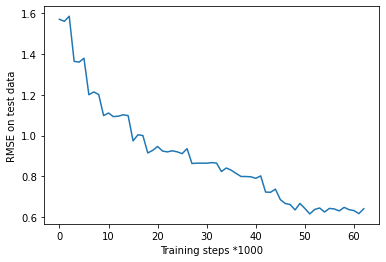

In [281]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *1000")
ax.set_ylabel("RMSE on test data")
plt.plot(rmse_evolution)
plt.show()

# Multiple plots

[6.038161754608154, 22.173749923706055, 23.51516342163086, 121.32780456542969, 84.37623596191406, 1827.892822265625, 13.463519096374512, 13.101374626159668, 12.854454040527344, 12.619606971740723]
[6.077156066894531, 22.157947540283203, 22.001792907714844, 48.69547653198242, 79.58250427246094, 146.56912231445312, 15.0438871383667, 14.466064453125, 14.166326522827148, 13.902145385742188]
[6.128620624542236, 21.45108413696289, 54.0301628112793, 3.798896074295044, 4.877624034881592, 9.212177276611328, 3.463322401046753, 1.2861989736557007, 0.6480376124382019, 0.4918895363807678]
[6.080233573913574, 20.977643966674805, 52.493621826171875, 4.110617637634277, 4.732529163360596, 7.960615634918213, 3.4565975666046143, 1.4252264499664307, 0.9316142797470093, 0.6115319728851318]
[6.127723217010498, 21.028438568115234, 50.98862838745117, 39.335208892822266, 56.99491500854492, 83.3930892944336, 14.89831256866455, 11.770726203918457, 10.488679885864258, 9.76795768737793]
[6.311974048614502, 21.4725

<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0c

[5.77085018157959, 18.961999893188477, 36.66959762573242, 27.760629653930664, 154.65553283691406, 5595.78857421875, 15019.484375, 8.999650955200195, 5.460452079772949, 4.654001712799072]
[5.683823108673096, 18.796226501464844, 40.46764373779297, 38.63180160522461, 329.8455505371094, 10555.56640625, 15.410909652709961, 13.787591934204102, 12.732758522033691, 12.06267261505127]
[5.502506256103516, 19.155948638916016, 28.283382415771484, 104.99537658691406, 34.06245040893555, 295.6584167480469, 7489.79833984375, 14.612950325012207, 14.065289497375488, 13.453153610229492]
[5.488346576690674, 19.374605178833008, 29.266504287719727, 158.908447265625, 36.99073791503906, 1194.4276123046875, 5906.9755859375, 246700.21875, 17606048219136.0, 4.038740542236918e+17]
[5.420110702514648, 18.913955688476562, 34.00028610229492, 101.21684265136719, 245.91287231445312, 91684.2890625, 3731618.0, 1355.82177734375, 40493968.0, 18728.072265625]
[5.402190208435059, 19.758914947509766, 34.40960693359375, 60.50

<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0c

[5.552350044250488, 17.21142578125, 32.36910629272461, 3.998436450958252, 15.870272636413574, 6.765532493591309, 8.536575317382812, 8.463876724243164, 2.0023837089538574, 0.9365593791007996]
[5.421132564544678, 17.478496551513672, 28.614665985107422, 27.905048370361328, 24.48141098022461, 37.44507598876953, 1032.83984375, 848.6915283203125, 311.3933410644531, 11.82982349395752]
[5.605257034301758, 17.63856315612793, 31.531774520874023, 3.133855104446411, 6.118531227111816, 10.596441268920898, 24.559289932250977, 47.01020812988281, 11.199262619018555, 6.157347679138184]
[5.794764995574951, 18.42208480834961, 31.005239486694336, 4.702237129211426, 23.83315086364746, 21.5113525390625, 24.267269134521484, 14.987234115600586, 6.815123558044434, 5.808962821960449]
[5.821946144104004, 18.314538955688477, 27.4627742767334, 6.347692966461182, 2.9005236625671387, 3.0421884059906006, 1.2740861177444458, 1.1215437650680542, 1.2764374017715454, 1.7654802799224854]
[5.596436977386475, 16.24369812011

<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0caec96c>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-181-c4cf0c

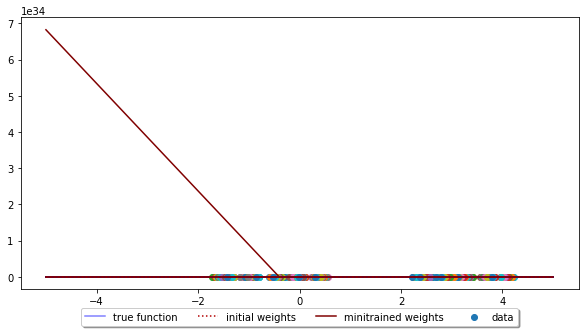

In [186]:
K=10
num_iterations = 50

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
function_tasks = SineDistribution(0.1, 5, 0, np.pi, -5, 5)
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):
    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)
    
    error += np.linalg.norm(task.true_sine(axis.cpu().clone().numpy()) - L)
    plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='lower right')

error = error/num_iterations
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

# RMSE evolution

In [ ]:
K = 10
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5 #Classic ones
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #It sucks

sine_tasks=SineDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
#NPs like: -1, 1, 0, np.pi/3, -3, 3
#Classic: 0.1, 5, 0, np.pi, -5, 5
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=10, num_metatasks=10)

rmse_evolution = []
for train_step in range(150):
    maml.outer_loop(num_epochs=100)
    num_iterations = 50
    sine_tasks=SineDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
    global_error = 0

    for i in range(num_iterations):
        og_net=maml.net.net
        optim=torch.optim.SGD
        lr=0.01
        
        task=sine_tasks.sample_task()
        x,y=task.sample_data(K)
        x=x.to(device)
        y=y.to(device)

        outputs,axis=test(og_net,x,y,lr,optim)
  
        error = 0
        L = []
        for i in range(len(x.numpy())):
            L.append(int((5+x.numpy()[i][0])*100))
        pred = []
        for i in range(len(x.numpy())):
            pred.append(outputs['minitrained'][L[i]][0])
        y_ = []
        for i in range(len(y.numpy())):
            y_.append(y.numpy()[i][0])
        global_error+=(np.linalg.norm(np.array(y_)-np.array(pred)))
    global_error = global_error/num_iterations
    rmse_evolution.append(global_error)

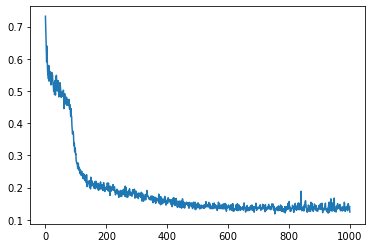

In [15]:
plt.plot(maml.meta_losses)